In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
import os
import itertools
import numpy.ma as ma
from tqdm import tqdm
import networkx as nx 
import time 
import planarity

In [2]:
year = 2020
corr = pd.read_csv(f'{year} first-level corr.csv',index_col=0)
corr

,居民服务维修业,交通运输仓储邮政业,建筑业,住宿和餐饮业,科学研究和技术服务业,制造业,采矿业,文体娱乐业,教育业,信息传输、软件和信息技术服务业,金融业,租赁和商务服务业,水利、环境和公共设施管理业,农林牧渔业,电热燃水生产和供应业,批发和零售业,综合业,房地产业,卫生和社会工作业
居民服务维修业,1.000000,0.207183,0.236646,0.154320,0.226405,0.110826,0.322219,0.249275,0.123344,0.358567,0.302209,0.093224,0.268093,0.211015,0.273998,0.255118,0.484282,0.175168,0.235725
交通运输仓储邮政业,0.207183,1.000000,0.410633,0.253216,0.425082,0.441468,0.277871,0.417651,0.365744,0.370094,0.362618,0.337374,0.348190,0.324012,0.325522,0.500407,0.385488,0.310992,0.493716
建筑业,0.236646,0.410633,1.000000,0.316863,0.401720,0.376860,0.320336,0.396134,0.931601,0.405755,0.298299,0.302025,0.398074,0.235542,0.372768,0.498262,0.338167,0.336842,0.430905
住宿和餐饮业,0.154320,0.253216,0.316863,1.000000,0.150868,0.349536,0.279736,0.214556,0.253447,0.269766,0.465568,0.310466,0.247667,0.214620,0.334887,0.264407,0.202810,0.454982,0.234337
科学研究和技术服务业,0.226405,0.425082,0.401720,0.150868,1.000000,0.474937,0.237203,0.403222,0.392518,0.512579,0.278615,0.409388,0.398291,0.358362,0.222428,0.659976,0.465581,0.192829,0.769794
制造业,0.110826,0.441468,0.376860,0.349536,0.474937,1.000000,0.337162,0.381523,0.338029,0.398363,0.416400,0.399861,0.316499,0.282442,0.445761,0.546442,0.322301,0.385930,0.552789
采矿业,0.322219,0.277871,0.320336,0.279736,0.237203,0.337162,1.000000,0.355599,0.169824,0.437266,0.635029,0.239733,0.363583,0.313964,0.514850,0.378648,0.542627,0.488485,0.353624
文体娱乐业,0.249275,0.417651,0.396134,0.214556,0.403222,0.381523,0.355599,1.000000,0.362586,0.504303,0.303596,0.346646,0.455420,0.273742,0.268288,0.496204,0.376407,0.214235,0.419090
教育业,0.123344,0.365744,0.931601,0.253447,0.392518,0.338029,0.169824,0.362586,1.000000,0.358038,0.143834,0.279184,0.316534,0.200801,0.266017,0.452223,0.247701,0.174272,0.414556
信息传输、软件和信息技术服务业,0.358567,0.370094,0.405755,0.269766,0.512579,0.398363,0.437266,0.504303,0.358038,1.000000,0.397708,0.334973,0.442795,0.359565,0.366047,0.567161,0.597908,0.294229,0.534191


In [5]:
distance_m = pd.DataFrame(np.tril(np.sqrt((1-corr)/2)))
distance_m.columns=corr.columns
distance_m.index=corr.columns

In [6]:
distance_m

,居民服务维修业,交通运输仓储邮政业,建筑业,住宿和餐饮业,科学研究和技术服务业,制造业,采矿业,文体娱乐业,教育业,信息传输、软件和信息技术服务业,金融业,租赁和商务服务业,水利、环境和公共设施管理业,农林牧渔业,电热燃水生产和供应业,批发和零售业,综合业,房地产业,卫生和社会工作业
居民服务维修业,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
交通运输仓储邮政业,0.629610,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
建筑业,0.617800,0.542848,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
住宿和餐饮业,0.650262,0.611058,0.584439,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
科学研究和技术服务业,0.621930,0.536152,0.546937,0.651587,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
制造业,0.666773,0.528456,0.558185,0.570291,0.512378,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
采矿业,0.582143,0.600886,0.582951,0.600110,0.617575,0.575690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
文体娱乐业,0.612668,0.539606,0.549484,0.626675,0.546250,0.556092,0.567627,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
教育业,0.662063,0.563141,0.184931,0.610963,0.551127,0.575313,0.644273,0.564541,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
信息传输、软件和信息技术服务业,0.566318,0.561207,0.545090,0.604249,0.493671,0.548469,0.530440,0.497844,0.566552,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [7]:
zipped = []
for i in range(len(distance_m.columns)):
    zipped.append(list(zip([distance_m.columns[i]]*distance_m.shape[0],distance_m.index,distance_m[distance_m.columns[i]])))
List_flat = []
for i in zipped:
    for j in i:
        if not np.isnan(j[2]):
            List_flat.append(j)
s_List_flat = list(set(List_flat))
# print(len(s_List_flat))
List = []
for i in range(len(s_List_flat)):
    # print(s_List_flat[i])
    if float(s_List_flat[i][2])!=0:
        List.append(s_List_flat[i])
G = nx.Graph()
G.add_weighted_edges_from(List)
#     return G

def sort_graph_edges_dist(G):
    sorted_edges = []
    tmp = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse = False)
    for source, dest, data in tmp: # in descending order!
        sorted_edges.append({'source': source,
                            'dest': dest,
                            'weight': data['weight']})
    return sorted_edges

def compute_PMFG(G):
    PMFG = nx.Graph() 
    ne_total = G.number_of_edges()
    nb_nodes = len(G.nodes)
    ne_pmfg = 3*(nb_nodes-2)
    sorted_edges = sort_graph_edges_dist(G)
    t0 = time.time()
    for i, edge in enumerate(sorted_edges):
        PMFG.add_edge(edge['source'], edge['dest'], weight = edge['weight'])
        if not planarity.is_planar(PMFG):
            PMFG.remove_edge(edge['source'], edge['dest'])
        ne = PMFG.number_of_edges()
        print("Generating PMFG... added edges in PMFG %d/%d (%.2f%%) lookup edges in G %d/%d (%.2f%%) Elapsed TIme %.2f [sec]"            %(ne, ne_pmfg, (ne/ne_pmfg)*100, i, ne_total, (i+1/ne_total)*100, time.time()-t0), end="\r")
        if ne == ne_pmfg:
            break
    return PMFG

In [8]:
pmfg = compute_PMFG(G)

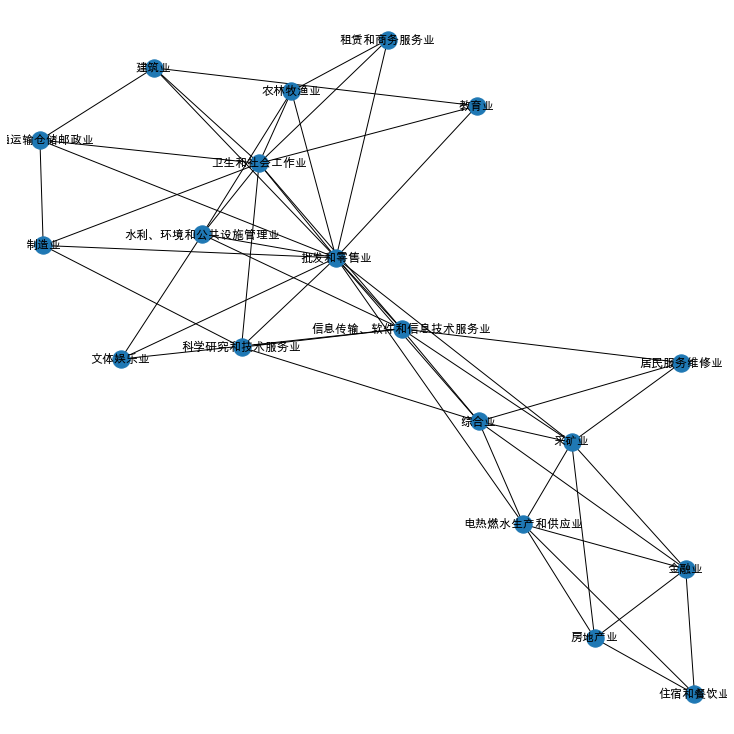

In [9]:
plt.figure(figsize=(10,10))
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
nx.draw(pmfg,with_labels = True)

In [10]:
degree = dict(pmfg.degree())
sorted(degree.items(), key=lambda x:x[1],reverse=True)

[('批发和零售业', 14),
 ('卫生和社会工作业', 10),
 ('信息传输、软件和信息技术服务业', 8),
 ('采矿业', 7),
 ('综合业', 7),
 ('电热燃水生产和供应业', 6),
 ('科学研究和技术服务业', 5),
 ('金融业', 5),
 ('水利、环境和公共设施管理业', 5),
 ('建筑业', 4),
 ('房地产业', 4),
 ('制造业', 4),
 ('交通运输仓储邮政业', 4),
 ('农林牧渔业', 4),
 ('教育业', 3),
 ('文体娱乐业', 3),
 ('居民服务维修业', 3),
 ('租赁和商务服务业', 3),
 ('住宿和餐饮业', 3)]

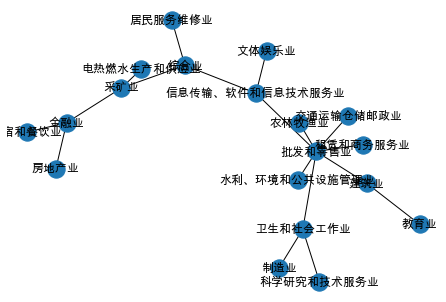

In [11]:
mst = nx.minimum_spanning_tree(G)
nx.draw(mst,with_labels=True)

In [12]:
nodes = G.nodes
edges = dict(G.edges)
# edges


In [14]:
from itertools import combinations

In [15]:
def weight_to_corr(weight):
    return 1-2*weight**2

In [16]:
tmp = list(G.nodes)
Impation = {}
for i in range(len(G.nodes)):
    a = list(G.nodes)
    # 除去一个节点
    print(tmp[i])
    a.remove(tmp[i])
    # 这个节点外所有的组合，随后获取其相关系数---即Cij
    cobs = list(combinations(a,2))
    # print('除此点外所有组合: \n',cobs)
    # 获得Cik和Cjk
    for j in range(len(cobs)):
        C_ij_k_list = []
        try:
            C_ik = weight_to_corr(edges[(tmp[i],cobs[j][0])]['weight'])
        except:
            C_ik = weight_to_corr(edges[(cobs[j][0],tmp[i])]['weight'])
        try:
            C_jk = weight_to_corr(edges[(tmp[i],cobs[j][1])]['weight'])
        except:
            C_jk = weight_to_corr(edges[(cobs[j][1],tmp[i])]['weight'])
        try:
            C_ij = weight_to_corr(edges[(cobs[j][0],cobs[j][1])]['weight'])
        except:
            C_ij = weight_to_corr(edges[(cobs[j][1],cobs[j][0])]['weight'])
        C_ij_k_list.append(C_ij-(C_ij-C_ik*C_jk)/np.sqrt((1-C_ik**2)*(1-C_jk**2)))
    Impation[tmp[i]]=sum(C_ij_k_list)/((2*len(G.nodes)-1)*(len(G.nodes)-2))


建筑业
采矿业
科学研究和技术服务业
文体娱乐业
交通运输仓储邮政业
综合业
租赁和商务服务业
信息传输、软件和信息技术服务业
水利、环境和公共设施管理业
房地产业
卫生和社会工作业
农林牧渔业
制造业
电热燃水生产和供应业
批发和零售业
居民服务维修业
金融业
教育业
住宿和餐饮业


In [17]:
sorted(Impation.items(), key=lambda x:x[1],reverse=True)

[('建筑业', 0.0005954316288590729),
 ('住宿和餐饮业', 0.00018069081538598882),
 ('制造业', 0.00015900328936905702),
 ('批发和零售业', 0.00015549503495983813),
 ('信息传输、软件和信息技术服务业', 0.00012556649980422917),
 ('卫生和社会工作业', 0.0001220545794601648),
 ('交通运输仓储邮政业', 0.00011894721595420145),
 ('电热燃水生产和供应业', 0.00011525178289349898),
 ('租赁和商务服务业', 0.00011246882398430686),
 ('水利、环境和公共设施管理业', 0.00010011446124609363),
 ('文体娱乐业', 9.614499146392849e-05),
 ('房地产业', 8.718015963461822e-05),
 ('金融业', 6.442178277468643e-05),
 ('科学研究和技术服务业', 6.331518097547428e-05),
 ('综合业', 6.239806114821944e-05),
 ('采矿业', 5.688485613652647e-05),
 ('农林牧渔业', 5.341701392040582e-05),
 ('教育业', 2.7519187017259174e-05),
 ('居民服务维修业', 2.2840608740721664e-05)]